# Feature Engineering - part 2

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import jenkspy # for Jenks natural breaks

from optbinning import OptimalBinning

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

## Binning - based on the `churn` dataset
Alternatively we can consider binning, ex: combining continuous values into intervals.

We will show this on the example of the `churn` data, as this is more common for classification tasks and includes so called optimal binning.

In [15]:
churn_train_encoded = pd.read_pickle('data/churn_train_encoded.pkl')
churn_test_encoded = pd.read_pickle('data/churn_test_encoded.pkl')

churn_train_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_1
4694,799562,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,...,0.000,0,0,1,0,0,0,0,1,0
1263,282706,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,...,0.050,1,0,0,0,0,0,0,0,0
4427,837683,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,...,0.217,1,0,0,1,0,0,0,0,0
8746,384742,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,...,0.196,1,0,1,0,0,0,0,0,0
4386,618362,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,...,0.000,1,0,1,0,0,0,0,0,0


In [17]:
churn_train_X = churn_train_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
churn_train_y = churn_train_encoded['account_status_1']

In [19]:
# and apply the simple logistic regression using all non-transformed variables
# (apart from customer_id) checking its performance on the new dataset with 5-Fold CV

cv5 = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 123
)

# and use a function cross_val_score()
# - however, it allows for only one scoring metric at a time

cross_val_score(
    estimator = LogisticRegression(
        penalty = None,
        max_iter = 1000,
        tol = 0.01
    ),
    X = churn_train_X,
    y = churn_train_y,
    cv = cv5,
    scoring = 'balanced_accuracy',
    n_jobs = -1
).mean()

0.7096573172432666

In [21]:
# using a wide range of metrics (also level-specific)

# Defining custom metrics for individual levels
def recall_for_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label = 0)

def recall_for_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label = 1)

def precision_for_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label = 0)

def precision_for_class_1(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label = 1)

def f1_for_class_0(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label = 0)

def f1_for_class_1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label = 1)


# and lets put it together into a list of scoring metrics
scoring_full = {
    'accuracy': 'accuracy',
    # add custom scorers for each class
    'recall_class_0': make_scorer(recall_for_class_0),
    'recall_class_1': make_scorer(recall_for_class_1),
    'balanced_accuracy': 'balanced_accuracy', # or alternatively 'recall_macro'
    'precision_class_0': make_scorer(precision_for_class_0),
    'precision_class_1': make_scorer(precision_for_class_1),
    'f1_class_0': make_scorer(f1_for_class_0),
    'f1_class_1': make_scorer(f1_for_class_1),
    'roc_auc': 'roc_auc'
}

# and apply it to our model - we need to use another function than before
# - cross_validate() which  allows for multiple scoring metrics
# - it returns a dictionary with all the metrics for each fold

performance_benchmark = cross_validate(
    estimator = LogisticRegression(
        penalty = None,
        max_iter = 1000,
        tol = 0.01
    ),
    X = churn_train_X,
    y = churn_train_y,
    cv = cv5,
    scoring = scoring_full,
    n_jobs = -1,
    return_train_score = False  # set True if you also want train scores
)

# performance_benchmark is a dictionary; lets convert it to a DataFrame
performance_benchmark_df = pd.DataFrame(performance_benchmark)
performance_benchmark_df

,fit_time,score_time,test_accuracy,test_recall_class_0,test_recall_class_1,test_balanced_accuracy,test_precision_class_0,test_precision_class_1,test_f1_class_0,test_f1_class_1,test_roc_auc
0,0.479625,0.028504,0.876587,0.961116,0.451064,0.706090,0.898104,0.697368,0.928542,0.547804,0.862981
1,0.525666,0.038172,0.879408,0.962312,0.437500,0.699906,0.901176,0.685315,0.930741,0.534060,0.873374
2,0.501781,0.030419,0.894217,0.973289,0.463636,0.718463,0.908100,0.761194,0.939565,0.576271,0.891896
3,0.310548,0.034933,0.892731,0.968569,0.451923,0.710246,0.911284,0.712121,0.939054,0.552941,0.892242
4,0.512117,0.033833,0.879323,0.970815,0.456349,0.713582,0.891956,0.771812,0.929716,0.573566,0.877076


In [25]:
# Average of each column (apart from the first two) across all folds
print('\nAverage over all folds')
print(performance_benchmark_df.iloc[:, 2:].mean())

# not very good in predicting churning clients:
# - recall for class 1 = 0.46, precision also low


Average over all folds
test_accuracy             0.884453
test_recall_class_0       0.967220
test_recall_class_1       0.452094
test_balanced_accuracy    0.709657
test_precision_class_0    0.902124
test_precision_class_1    0.725562
test_f1_class_0           0.933524
test_f1_class_1           0.556928
test_roc_auc              0.879514
dtype: float64


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


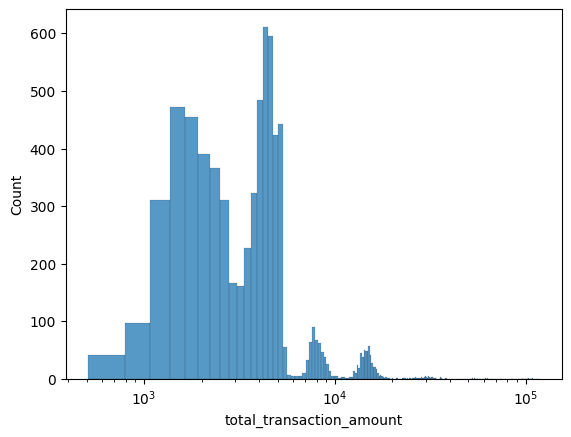

In [29]:
# lets check the distribution of one of the predictors

sns.histplot(
    churn_train_encoded['total_transaction_amount']
)

plt.xscale('log')

# there seem to be clear "natural" breaks in the distribution (5 or 4)

In [55]:
churn_train_encoded.total_transaction_amount.value_counts().head(10)

total_transaction_amount
5207.296236    286
4253.000000     10
4037.000000      8
4509.000000      8
4220.000000      8
4697.000000      7
4518.000000      7
2229.000000      7
4520.000000      7
4869.000000      7
Name: count, dtype: int64

---
### Full binning
Every value as a different level.

This is most certainly too much and does not make sense here as there are many different values of `total_transaction_amount` and they do not repeat for many customers.

This type of transformation could be applied for quantitative variables that take a limited number of values that repeat quite often - e.g. age

### Division into `quantile groups`
One can divide a quantitative variable into quantile groups (equal sized) - lets show this on the example of quantile groups (5)

In [39]:
# To calculate quantiles (quantiles in this case: 0%, 20%, 40%, 60%, 80%, 100%)
# we can use the quantile() method
quantiles=churn_train_encoded['total_transaction_amount'].quantile(q = np.linspace(0,1,6))

print(quantiles)

0.0       510.000000
0.2      1961.000000
0.4      3428.800000
0.6      4399.000000
0.8      5207.296236
1.0    117159.000000
Name: total_transaction_amount, dtype: float64


In [45]:
# and use the result of quantile() as breaks in the cut() method

churn_train_encoded['total_transaction_amount_quintiles'] = pd.cut(
    churn_train_encoded['total_transaction_amount'],
    bins = quantiles,
    include_lowest = True
)

# in this case groups will not always have the same size
# (all repeating values will always be in the same group)
churn_train_encoded['total_transaction_amount_quintiles'].value_counts(sort = False)

total_transaction_amount_quintiles
(509.999, 1961.0]       1419
(1961.0, 3428.8]        1416
(3428.8, 4399.0]        1419
(4399.0, 5207.296]      1576
(5207.296, 117159.0]    1258
Name: count, dtype: int64

In [49]:
# lets check how the model changes

# first we create a new churn_train_X matrix with the new categorical variable
# - we drop the original total_transaction_amount variable

churn_train_X_quintiles = churn_train_X.copy().drop(['total_transaction_amount'], axis=1)
churn_train_X_quintiles['total_transaction_amount_quintiles'] = churn_train_encoded['total_transaction_amount_quintiles']

# and recode the new categorical variable into dummies (one-hot encoding)
churn_train_X_quintiles = pd.get_dummies(
    churn_train_X_quintiles,
    columns = ['total_transaction_amount_quintiles'],
    drop_first = True,
    dtype = np.int8
)

churn_train_X_quintiles.head()

,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,credit_card_debt_balance,...,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,"total_transaction_amount_quintiles_(1961.0, 3428.8]","total_transaction_amount_quintiles_(3428.8, 4399.0]","total_transaction_amount_quintiles_(4399.0, 5207.296]","total_transaction_amount_quintiles_(5207.296, 117159.0]"
4694,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,0.0,...,1,0,0,0,0,1,0,0,1,0
1263,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,1591.0,...,0,0,0,0,0,0,0,1,0,0
4427,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,1189.0,...,0,1,0,0,0,0,0,0,0,1
8746,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,1869.0,...,1,0,0,0,0,0,0,0,0,0
4386,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [51]:
# and check the performance of the model

performance_benchmark_quintiles = cross_validate(
    estimator = LogisticRegression(
        penalty = None,
        max_iter = 1000,
        tol = 0.01
    ),
    X = churn_train_X_quintiles, # CORRECT training set!
    y = churn_train_y,
    cv = cv5,
    scoring = scoring_full,
    n_jobs = -1,
    return_train_score = False # set True if you also want train scores
)

# performance benchmark is a dictionary; lets convert it to a DataFrame
performance_benchmark_quintiles_df = pd.DataFrame(performance_benchmark_quintiles)

# average of each column (apart from the first-two) across all Folds
print('\nAverage over all folds')
print(performance_benchmark_quintiles_df.iloc[:, 2:].mean())

# AUC, balanced accuracy, recall for class 1 improved


Average over all folds
test_accuracy             0.897010
test_recall_class_0       0.966871
test_recall_class_1       0.532672
test_balanced_accuracy    0.749771
test_precision_class_0    0.915170
test_precision_class_1    0.754355
test_f1_class_0           0.940294
test_f1_class_1           0.624164
test_roc_auc              0.905539
dtype: float64


---
### Division based on Jenk's "natural breaks"
One can divide a quantitative variable into groups based on automatically identified "natural breaks" in their distribution (relatively lower frequency in some intervals) - lets show this on the example division into 5 groups.

In [63]:
breaks = jenkspy.jenks_breaks(
    churn_train_encoded['total_transaction_amount'],
    5 # number of intervals
)

# Jenks Natural Breaks
print(breaks)

[510.0, 3505.0, 9919.0, 24871.0, 66479.0, 117159.0]


In [67]:
# as before, lets use the result as breaks in the cut() method

churn_train_encoded['total_transaction_amount_nbreaks'] = pd.cut(
    churn_train_encoded['total_transaction_amount'],
    bins = breaks,
    include_lowest = True
)

churn_train_encoded['total_transaction_amount_nbreaks'].value_counts(sort = False)

# the last group is quite small - maybe we should merge it with the previous one
# [merging that 90 with 20 ...]

total_transaction_amount_nbreaks
(509.999, 3505.0]      2900
(3505.0, 9919.0]       3516
(9919.0, 24871.0]       562
(24871.0, 66479.0]       90
(66479.0, 117159.0]      20
Name: count, dtype: int64

In [69]:
# lets check how the model changes now

# first we create a new churn_train_X matrix with new categorical variable

churn_train_X_nbreaks = churn_train_X.copy().drop(['total_transaction_amount'], axis=1)
churn_train_X_nbreaks['total_transaction_amount_nbreaks'] = churn_train_encoded['total_transaction_amount_nbreaks']

# and recode the new categorical variable into dummies (one-hot encoding)
churn_train_X_nbreaks = pd.get_dummies(
    churn_train_X_nbreaks,
    columns = ['total_transaction_amount_nbreaks'],
    drop_first = True,
    dtype = np.int8
)

churn_train_X_nbreaks.head()

,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,credit_card_debt_balance,...,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,"total_transaction_amount_nbreaks_(3505.0, 9919.0]","total_transaction_amount_nbreaks_(9919.0, 24871.0]","total_transaction_amount_nbreaks_(24871.0, 66479.0]","total_transaction_amount_nbreaks_(66479.0, 117159.0]"
4694,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,0.0,...,1,0,0,0,0,1,1,0,0,0
1263,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,1591.0,...,0,0,0,0,0,0,1,0,0,0
4427,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,1189.0,...,0,1,0,0,0,0,0,1,0,0
8746,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,1869.0,...,1,0,0,0,0,0,0,0,0,0
4386,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [71]:
# and check the performance of the model

performance_benchmark_nbreaks = cross_validate(
    estimator = LogisticRegression(
        penalty = None,
        max_iter = 1000,
        tol = 0.01
    ),
    X = churn_train_X_nbreaks, # CORRECT training set!
    y = churn_train_y,
    cv = cv5,
    scoring = scoring_full, # defined above: includes all metrics
    n_jobs = -1,
    return_train_score = False # set True if you also want train score
)

# performance_benchmark is a dictionary; lets convert it to a DataFrame
performance_benchmark_nbreaks_df = pd.DataFrame(performance_benchmark_nbreaks)

# average of each column (apart from the first two) across all Folds
print('\nAverage over all folds')
print(performance_benchmark_nbreaks_df.iloc[:, 2:].mean())

# here there is no improvement in the model performance


Average over all folds
test_accuracy             0.884594
test_recall_class_0       0.969240
test_recall_class_1       0.442310
test_balanced_accuracy    0.705775
test_precision_class_0    0.900774
test_precision_class_1    0.732307
test_f1_class_0           0.933740
test_f1_class_1           0.551365
test_roc_auc              0.877285
dtype: float64


In [77]:
import warnings
warnings.filterwarnings('ignore')

---
### Optimal (supervised) binning

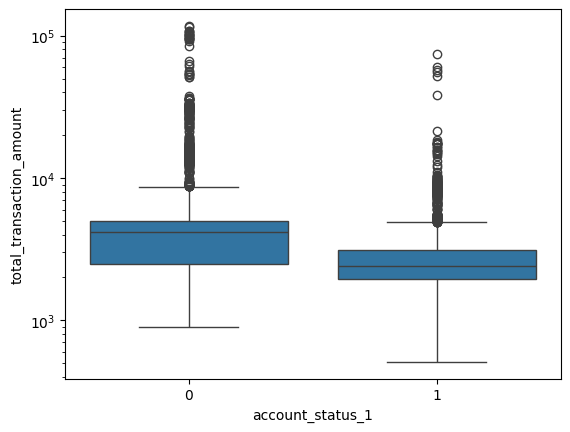

In [85]:
# lets check if/how its distribution differs for churning and non-churning customers

sns.boxplot(
    x = 'account_status_1',
    y = 'total_transaction_amount',
    data = churn_train_encoded
)

plt.yscale('log') # very useful when scaling differs

# looks like people with higher total_transaction_amount churn less often

The **WOE** tells the predictive power of an independent variable in relation to the dependent variable.

Generally:

 WOE_i = ln(% of non-events / % events) in group_i -
          ln(% of non-events / % events) in whole sample

WOE helps to transform a continuous independent variable into a set of groups or bins based on similarity of dependent variable distribution

For **continuous** independent variable:

1. start with bins (eg. 10-20 equal sized) for a continuous independent variable
2. combine categories with similar WOE values
3. replace variable levels with the values of WOE
4. use WOE values rather than input values in your model

For **categorical** independent variables:

1. Combine categories with similar WOE
2. create new categories of an independent variable with continuous WOE values.

In [93]:
# lets try to apply optimal binning to the same variable

# lets initialize the binning object
# we pass the variable name, its data type, and a solver,
# in this case, we choose the constraint programming solver

optb = OptimalBinning(
     name = 'total_transaction_amount',
     dtype = 'numerical', # 'categorical' or 'numerical'
     # max_n_prebins = 20, # maximum number of prebins, 20 by default
     solver = 'cp' # "mip" (mixed-integer programming solver) alternatively
)

# for categorical variables you can additionally use 
# cat_cutoff = 0.1 to create bin "others" with categories
# in which the percentage of occurences is below 10%
# (any other value is possible). This will merge rare categories

# we fit the optimal binning object with arrays x and y

x = churn_train_encoded['total_transaction_amount'].values # predictor
y = churn_train_encoded['account_status_1'].values # target

optb.fit(x, y)

OptimalBinning(name='total_transaction_amount')

In [105]:
# The optimal binning algorithms return a binning table
# which displays the binned data and several metrics for each bin

binning_table = optb.binning_table

# the method build() returns a pandas.DataFrame
binning_table.build() # used only for optimal binning

# "total_transaction_ammount" was categorized into 8 bins

# the binning table includes the following columns:
#   Bin: the intervals delimited by the optimal split points.
#   Count: the number of records for each bin.
#   Count (%): the percentage of records for each bin.
#   Non-event: the number of event records (y=0) for each bin.
#   Event: the number of event records (y=1) for each bin.
#   Event rate: the percentage of event records for each bin.
#   WoE: the Weight-of-Evidence for each bin.
#   IV: the Information Value for each bin.

#   JS: the Jensen-Shannon divergence for each bin
#       it is a statistic used to measure the similarity between two probability 
#       distributions
#       - in this context, the distribution of events (y=1) and non-events (y=0)
#   JS = 0 means the event and non-event distributions in that bin are identical.
#   High JS indicates a large difference in the distribution, suggesting good separation
#   power.

# The last row shows the total number of records, non-event records, event records, 
# and IV and JS.

# The sum of JS values across all bins provides a global measure of how well the binning
# separates events from non-events across the entire feature.

# Caution!!! It is not a probability or a bounded metric!
#    =>  values closer to 0 suggest poor separation,
#    =>  and higher values suggest strong separation.

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1291.50)",355,0.050085,235,120,0.338028,-0.980979,0.064601,7.766101e-03
1,"[1291.50, 2936.50)",2195,0.309678,1474,721,0.328474,-0.937977,0.361345,4.358189e-02
2,"[2936.50, 3555.50)",395,0.055728,374,21,0.053165,1.226661,0.054501,6.415271e-03
3,"[3555.50, 4041.50)",589,0.083098,584,5,0.008489,3.107391,0.291405,2.648004e-02
4,"[4041.50, 4723.00)",1406,0.198363,1400,6,0.004267,3.799396,0.874111,7.071577e-02
5,"[4723.00, 5185.50)",594,0.083804,566,28,0.047138,1.353317,0.095489,1.110126e-02
6,"[5185.50, 5417.00)",371,0.052342,324,47,0.126685,0.277523,0.003663,4.564038e-04
7,"[5417.00, inf)",1183,0.166902,992,191,0.161454,-0.005623,0.000005,6.608456e-07
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


In [111]:
# you can retrieve the split points with the splits attribute

print('Optimal splits:', optb.splits)

Optimal splits: [1291.5 2936.5 3555.5 4041.5 4723.  5185.5 5417. ]


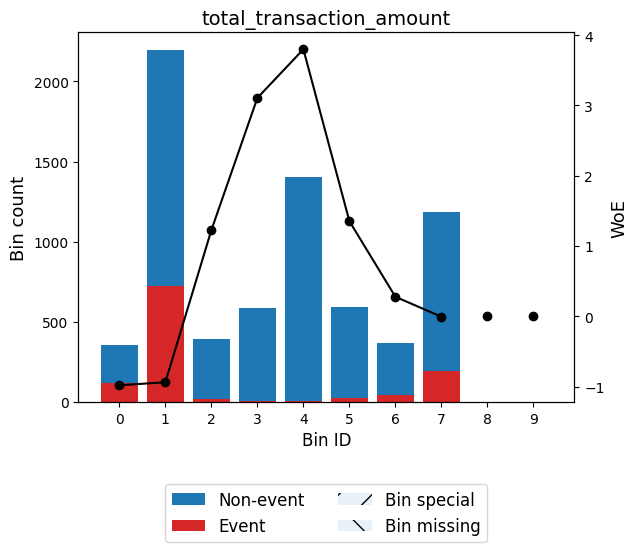

In [121]:
# lets see some useful plots

# histogram (red and blue) and WoE or event rate curve (black line).
# the Bin ID corresponds to the binning table index

binning_table.plot(metric = 'woe')

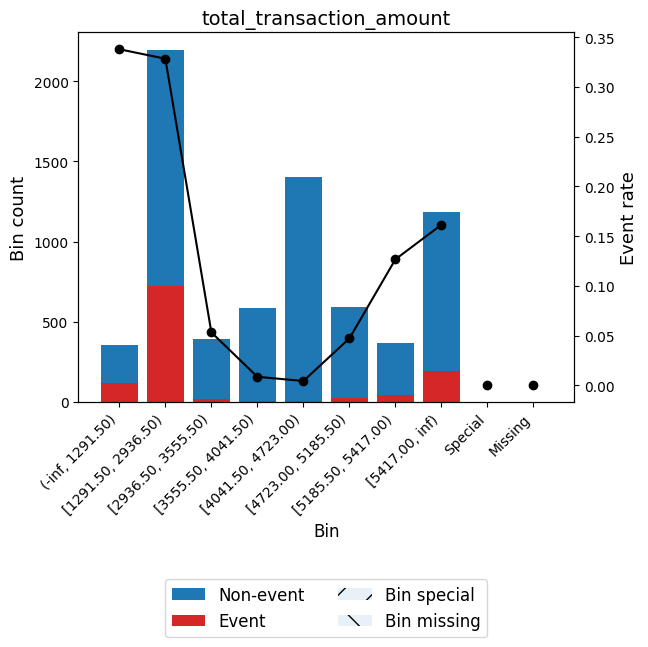

In [127]:
# Histogram (red and blue) and event rate
# - or share of churning customers (black line)
binning_table.plot(
    metric = 'event_rate',
    show_bin_labels = True
)

# one can see that WoE is inversely related to the event rate

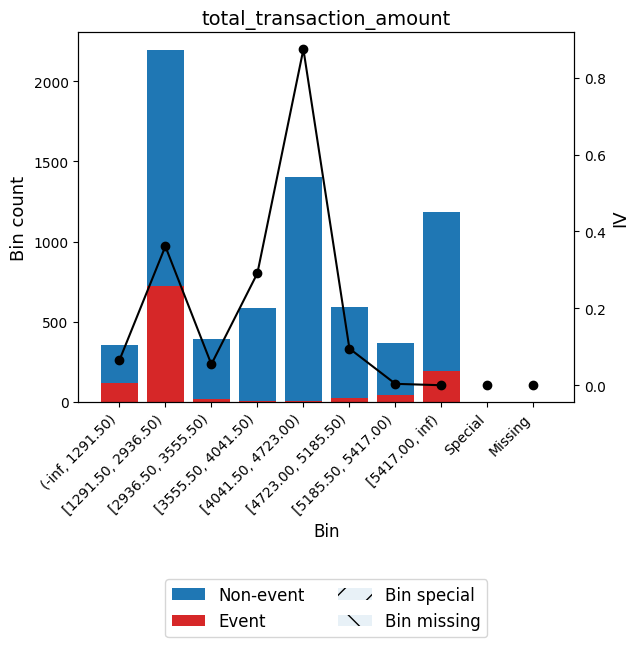

In [133]:
binning_table.plot(metric = 'iv', show_bin_labels = True)

In [135]:
# now we can either simply apply the binning based on the splits
# or we can use the values of WoE to create a new NUMERICAL variable

# lets transform our original data into WoE

# and create a new variable in the dataset
churn_train_encoded['total_transaction_amount_woe'] = optb.transform(x, metric = 'woe')

# lets check the distribution of the new variable
churn_train_encoded['total_transaction_amount_woe'].value_counts(sort = False)

# we converted the original numerical variable with MANY values
# into a categorical variable with just FEW - here 8 values (bins)

total_transaction_amount_woe
 1.353317     594
 3.107391     589
-0.005623    1183
-0.937977    2195
 3.799396    1406
 1.226661     395
 0.277523     371
-0.980979     355
Name: count, dtype: int64

In [137]:
# lets check how the model changes now

# first we create a new churn_train_X matrix
# with the new categorical variable

churn_train_X_WoE = churn_train_X.copy().drop(columns = ['total_transaction_amount'])
churn_train_X_WoE['total_transaction_amount_woe'] = churn_train_encoded['total_transaction_amount_woe']

# and check the performance of the model

performance_benchmark_WoE = cross_validate(
    estimator = LogisticRegression(penalty = None,
                                   max_iter = 1000,
                                   tol = 0.01),
    X = churn_train_X_WoE,
    y = churn_train_y,
    cv = cv5,
    scoring = scoring_full,
    n_jobs = -1,
    return_train_score = False)  # set True if you also want train scores

# performance_benchmark is a dictionary; let's convert it to a DataFrame
performance_benchmark_WoE_df = pd.DataFrame(performance_benchmark_WoE)

# Average of each column (apart from the first two) across all folds
print("\nAverage over all folds")
print(performance_benchmark_WoE_df.iloc[:,2:].mean())


Average over all folds
test_accuracy             0.893765
test_recall_class_0       0.963226
test_recall_class_1       0.530926
test_balanced_accuracy    0.747076
test_precision_class_0    0.914739
test_precision_class_1    0.733209
test_f1_class_0           0.938337
test_f1_class_1           0.615625
test_roc_auc              0.899468
dtype: float64


In [139]:
# lets compare the performance of all models

# first we create a new DataFrame
# with the performance of all models

performance_benchmark_all = pd.DataFrame({
    'Benchmark': performance_benchmark_df.iloc[:, 2:].mean(),
    'Quintiles': performance_benchmark_quintiles_df.iloc[:, 2:].mean(),
    'Natural breaks': performance_benchmark_nbreaks_df.iloc[:, 2:].mean(),
    'WoE': performance_benchmark_WoE_df.iloc[:, 2:].mean()
})

performance_benchmark_all.head()

,Benchmark,Quintiles,Natural breaks,WoE
test_accuracy,0.884453,0.897010,0.884594,0.893765
test_recall_class_0,0.967220,0.966871,0.969240,0.963226
test_recall_class_1,0.452094,0.532672,0.442310,0.530926
test_balanced_accuracy,0.709657,0.749771,0.705775,0.747076
test_precision_class_0,0.902124,0.915170,0.900774,0.914739


In [141]:
# lets plot all performance metrics of all models
# on a single plot

# Lets add an index (with metric names) as a column in the DataFrame
performance_benchmark_all = performance_benchmark_all.reset_index()
performance_benchmark_all = performance_benchmark_all.rename(columns = {'index': 'Metric'})
# remove the prefix "test_" from the metric names
performance_benchmark_all['Metric'] = performance_benchmark_all['Metric'].str.replace('test_', '')

performance_benchmark_all.head()

,Metric,Benchmark,Quintiles,Natural breaks,WoE
0,accuracy,0.884453,0.897010,0.884594,0.893765
1,recall_class_0,0.967220,0.966871,0.969240,0.963226
2,recall_class_1,0.452094,0.532672,0.442310,0.530926
3,balanced_accuracy,0.709657,0.749771,0.705775,0.747076
4,precision_class_0,0.902124,0.915170,0.900774,0.914739


<Figure size 1200x600 with 0 Axes>

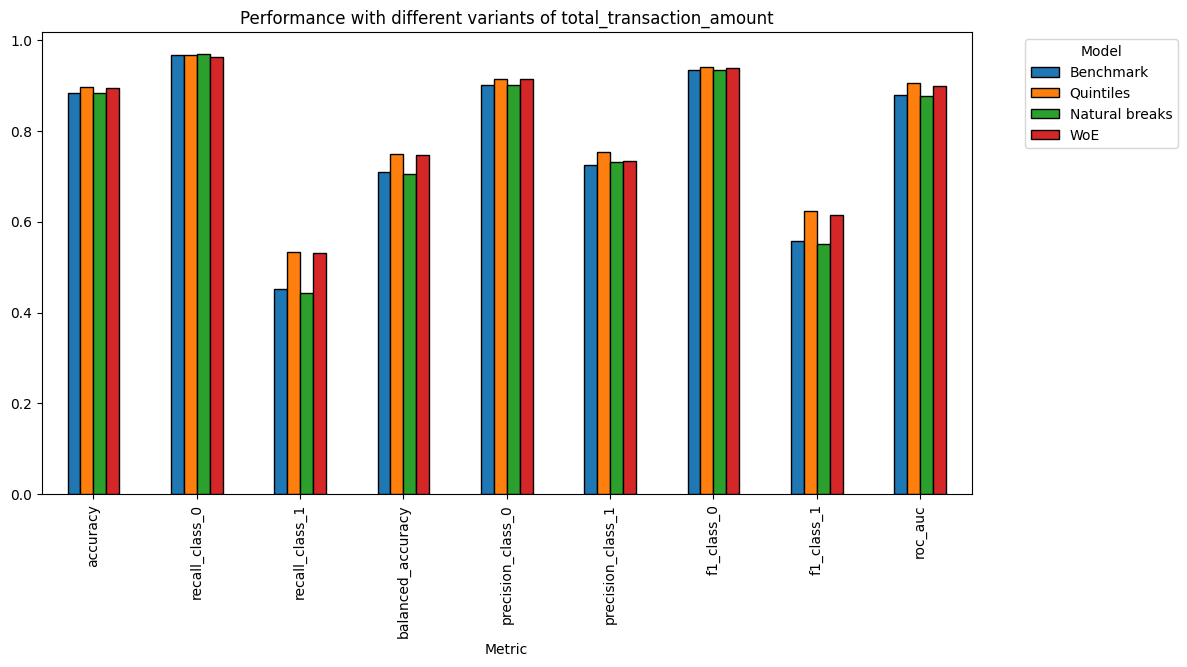

In [143]:
plt.figure(figsize = (12, 6))

performance_benchmark_all.plot(
    x = 'Metric',
    kind = 'bar',
    figsize = (12, 6),
    legend = True,
    title = 'Performance with different variants of total_transaction_amount',
    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
    edgecolor = 'black'
)

plt.legend(
    title = 'Model',
    bbox_to_anchor = (1.05, 1), loc = 'upper left'
)

Looks like quintiles and WoE seem to improve several metrics like: balanced accuracy, AUC and recall for 1s.

Remember that here we modified JUST A SINGLE VARIABLE!

### Information value to rank predictors by their usefullness in a binary classification

Last, but not least!

Information value is one of the most useful techniques to select important variables in a predictive model.
It helps to rank variables on the basis of their importance.

The IV is calculated using the following formula:

IV = Sum (% of non-events - % of events) * WOE

Information Value vs Variable Predictiveness:

* Less than 0.02 	-  Not useful for prediction
* 0.02 to 0.1 	 -    Weak predictive Power
* 0.1 to 0.3 	  -     Medium predictive Power
* 0.3 to 0.5 	-     Strong predictive Power
* $>$ 0.5 	    -      Suspicious Predictive Power

In [149]:
# lets load the churn training dataset BEFORE recoding categorical features from a pickle file

churn_train = pd.read_pickle('data/churn_train.pkl')

churn_train.head()

,customer_id,customer_age,customer_gender,customer_number_of_dependents,customer_education,customer_civil_status,customer_salary_range,customer_relationship_length,customer_available_credit_limit,credit_card_classification,...,period_inactive,contacts_in_last_year,credit_card_debt_balance,remaining_credit_limit,transaction_amount_ratio,total_transaction_amount,total_transaction_count,transaction_count_ratio,average_utilization,account_status
3681,425655,47,Unknown,4,Graduate,Married,60-80K,34,9261.0,Blue,...,3,0,1605,7656.0,0.571,8670,44,0.419,0.173,0
4863,533755,62,F,1,High School,Single,below 40K,36,1930.0,Blue,...,3,4,0,1930.0,0.331,1971,45,0.250,0.000,1
7575,775601,48,F,1,Unknown,Unknown,40-60K,36,2447.0,Blue,...,1,3,1991,456.0,0.719,4228,82,0.708,0.814,0
8249,837342,47,M,4,High School,Married,80-120K,37,2888.0,Blue,...,3,3,0,2888.0,0.717,4345,75,0.786,0.000,0
4723,521251,49,Unknown,3,Graduate,Married,below 40K,43,2174.0,Blue,...,3,2,785,1389.0,0.657,3890,78,0.660,0.361,0


In [153]:
y = churn_train["account_status"]

predictors = churn_train.drop(["account_status", "customer_id"], axis=1)

In [155]:
# store results here
iv_results = []

# iterate over all columns except target
for col in predictors:
    x = churn_train[col]
    # Determine variable type (categorical or numerical)
    # !!! we also treat numerical variables with few unique values as categorical!
    if x.dtype == 'category' or x.nunique() < 10:
        optb = OptimalBinning(name = col, dtype = 'categorical')
    else:
        optb = OptimalBinning(name = col, dtype = 'numerical')

    optb.fit(x, y)

    # Get IV
    binning_table = optb.binning_table.build()
    iv = binning_table['IV']
    iv = iv.iloc[-1]

    iv_results.append((col, iv))

In [157]:
iv_df = pd.DataFrame(iv_results, columns = ['Variable', 'IV']).sort_values(
    by = 'IV', ascending = False
)

print(iv_df)

                           Variable        IV
16          total_transaction_count  2.042630
15         total_transaction_amount  1.711465
12         credit_card_debt_balance  1.297503
17          transaction_count_ratio  0.999206
18              average_utilization  0.815597
14         transaction_amount_ratio  0.367101
10                  period_inactive  0.348366
11            contacts_in_last_year  0.273051
9                    total_products  0.197731
13           remaining_credit_limit  0.178251
7   customer_available_credit_limit  0.152388
3                customer_education  0.010424
1                   customer_gender  0.007893
6      customer_relationship_length  0.007116
2     customer_number_of_dependents  0.006436
5             customer_salary_range  0.006343
0                      customer_age  0.005189
4             customer_civil_status  0.003396
8        credit_card_classification  0.000023
